In [1]:
import os, glob, time, math
import numpy as np
import matplotlib.pyplot as plt, matplotlib.animation as animation, matplotlib.font_manager as fmg, matplotlib.colors as mpl_colors, matplotlib.patches as patches
from matplotlib.path import Path
import matplotlib.cm as cm
import seaborn as sns
from scipy.signal import savgol_filter, medfilt, argrelextrema
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
plt.rc('font', family='serif')
plt.rcParams['mathtext.fontset'] = 'cm'  # Use the Computer Modern font set for math symbols

# USE DIFFERENT FONT
font_dir = r'/scratch/work/silvap1/fonts/arial'
font_files = glob.glob(font_dir + "/*ttf")
for font_file in font_files:
    fm.fontManager.addfont(font_file)
plt.rcParams['font.family'] = 'Arial'

pcolors = ['#FF4136', '#FFDC00', '#2ECC40', '#0074D9', '#B10DC9', '#FF851B']
dcolors = ['#B20000', '#B28C00', '#006B36', '#002E5D', '#4D0039', '#B24700']
cTW = [(0, 0, 0, 0), (1, 1, 1, 1)]
triton = 1

colors = [#(0, 0, 0),   # black
          (.1, .1, .9),   # blue
          (.2, .8, 0),   # green
          (.8, .8, 0),   # yellow
          (.9, 0.4, 0), # orange
          (.9, 0, 0),   # red
          (.6, 0, .6)]#,   # pink
          #(1, 1, 1)]   # white
# Create the colormap
cmapTW = mpl_colors.ListedColormap(colors)
cmap = mpl_colors.LinearSegmentedColormap.from_list('my_colormap', list(colors))

#%matplotlib widget
%matplotlib inline
dpi = 300

if triton == 1:
    dir_path = r'/scratch/work/silvap1/temp' # CHANGE THIS FOLDER
    root = r'/scratch/work/silvap1'
    fsd = sorted(glob.glob(root + "/*mat_3d.npy"))
else:
    dir_path = r'\\home.org.aalto.fi\silvap1\data\Desktop\zahra\230414\temp' # CHANGE THIS FOLDER
    root = r'\\home.org.aalto.fi\silvap1\data\Desktop\zahra\230414'
    fsd = sorted(glob.glob(root + "\\*mat_3d.npy"))
fs = [f[-24:-11] for f in fsd]
#print(fs)

# Set figure size in centimeters
fig_width_cm = 5.5  # Width of the figure in centimeters
fig_height_cm = 5.5  # Height of the figure in centimeters
fig_width_in = fig_width_cm / 2.54  # Convert width to inches
fig_height_in = fig_height_cm / 2.54  # Convert height to inches

pcolor = sns.color_palette('rocket', 6)
clab = ['50 mW', '100 mW', '150 mW', '200 mW', '250 mW', '300 mW']

# Loading variables

- t: time of recording (measured by thermal camera)
- h: length of the helix (calculated using a python algorithm)
- rang1, rang2: angles of the helix at the boundaries (using minimum bounding rectangle method)
- el1, el2: angles of helix at the boundaries (using fitting of an ellipse, probably gives better results)
- tempMAX: maximum temperature measured in each instant of time (measured by the thermal camera)

In [2]:
t, h, rang1, rang2, el1, el2, tempMAX = [], [], [], [], [], [], []
avgh = 0
tmin = 1000
tOFF = np.zeros(6)
c0, c1, c2 = (0, 0, 6)
N = 1000
for c in range(c1, c2):
    t.append(np.load(root + '/' + fs[c] + '_time_3d.npy'))
    temp = np.load(root + '/' + fs[c] + '_measure.npy')
    h.append(temp[0])
    rang1.append(temp[1])
    rang2.append(temp[2])
    el1.append(temp[3])
    el2.append(temp[4])
    tempMAX.append(temp[5])
    # Calculate tOFF
    tsm = medfilt(tempMAX[c0], kernel_size=7)
    dT = np.diff(tsm)
    dT2 = np.diff(dT)
    threshold = -0.3
    extr = np.where(dT2 < threshold)[0]
    for l in range(len(extr)):
        if t[c0][extr[l]] > 60:
            tOFF[c0] = extr[l] + 1
            if t[c0][extr[l]] < tmin:
                tmin = t[c0][extr[l]]
            break
    c0 += 1

# Temperature plots

In the previous loading variables, 1 point or interest is calculated: the point where temperature drops drastically. After checking the plots it seems the rise of the max temperature is also easy to spot since there is no delay. The reason why these points need to be calculated lies in the method used for comparing the effect on the laser power in the sample XXX. Pedro triggered recording of the thermal camera ON and informs Sioban. When Pedro hears the shutter of the laser (click sound), Pedro triggers the timer. When the timer reaches close the 1 minute (60 seconds) Pedro makes a count down to trigger of the laser. Afterwards, 30 seconds are still recorded. Therefore, laser should be OFF in the measurement, then ON for 60 seconds, and again OFF. So, the plots can be aligned exactly when the laser is turned OFF because there's a significant drop in temperature. I've calculated the extreme points and selected the first extreme drop after the 60 seconds (drops should occur moreless between 60 and 65 seconds, depending on how in sync Pedro and Siohban. Analysing the region where plots should increase temperature, at time = 0s, it looks some points start ascending before 0, but less than 1 second.

t(off) [2.4 3.  2.6 1.8 3.6 2.2]


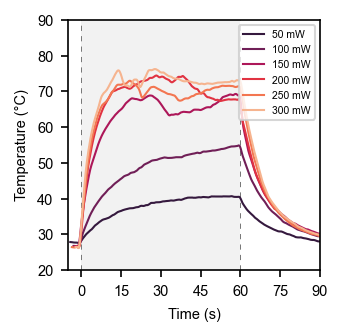

In [3]:
plt.close()
fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in), dpi = 150)
fig.patch.set_facecolor('None')
c0 = 0
on_color = 'green'   
off_color = 'red' 

for c in range(c1, c2):
    x = np.linspace(t[c0].min(), t[c0].max(), N)
    y = np.interp(x, t[c0], tempMAX[c0])
    ysm = savgol_filter(y, window_length=21, polyorder=2, mode='nearest')
    ti = t[c0][int(tOFF[c0])] - 60 #- tmin
    #ax.plot(t[c0]-ti, tempMAX[c0], '.', color = pcolor[c0], markersize=2, markeredgecolor='none', alpha = 0.5, zorder=3, label = clab[c0])
    ax.plot(x-ti, ysm, color = pcolor[c0], zorder=2, lw=1, alpha=1,label = clab[c0])
    #ax.plot([t[c0][int(tOFF[c0])]-ti, t[c0][int(tOFF[c0])]-ti], [20, 80], color='black', linewidth=1, linestyle='dashed', dashes=(10, 10), zorder = -1)
    c0 += 1
    
ax.plot([60, 60], [20, 100], color='black', linewidth=0.25, linestyle='dashed', dashes=(10, 10), zorder = -1)
ax.plot([0, 0], [20, 100], color='black', linewidth=0.25, linestyle='dashed', dashes=(10, 10), zorder = -1)
    
ax.legend(loc='best',prop=fmg.FontProperties(size=5))
ax.tick_params(axis='both', labelsize=7)
#ax.text(2, 70, 'Laser ON', fontsize=8, color='black', zorder=2, rotation=90)
ax.axvspan(0, 60, facecolor='gray', alpha=0.1, zorder=1)
#ax.axvspan(-5, 0, facecolor=off_color, alpha=0.1)
#ax.axvspan(60, 90, facecolor=off_color, alpha=0.1)
ax.set_xlim((-5,90))
ax.set_ylim((20, 90))
ax.set_xticks(np.arange(0, 95, 15));
ax.set_yticks(np.arange(20, 91, 10));
ax.set_ylabel('Temperature (°C)', fontsize=7)
ax.set_xlabel('Time (s)', fontsize=7);
print("t(off)", tOFF/5-60)
plt.savefig(root + r'/temperature_m734.pdf', format='pdf', dpi=dpi, bbox_inches='tight',pad_inches=0);

t(off) [2.4 3.  2.6 1.8 3.6 2.2]


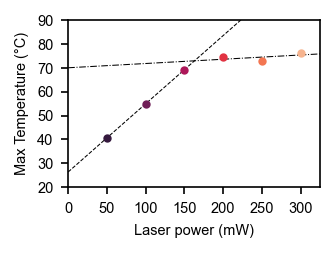

In [4]:
plt.close()
fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in*2/3), dpi = 150)
c0 = 0
on_color = 'green'   
off_color = 'red' 
tempmax = np.zeros(6)

for c in range(c1, c2):
    x = np.linspace(t[c0].min(), t[c0].max(), N)
    y = np.interp(x, t[c0], tempMAX[c0])
    ysm = savgol_filter(y, window_length=21, polyorder=2, mode='nearest')
    ti = t[c0][int(tOFF[c0])] - 60 #- tmin
    #ax.plot(t[c0]-ti, tempMAX[c0], '.', color = pcolor[c0], markersize=2, markeredgecolor='none', alpha = 0.5, zorder=3, label = clab[c0])
    ax.plot(50*(c+1), max(ysm), color = pcolor[c0], zorder=2, marker='.', alpha=1,label = clab[c0])
    tempmax[c0] = max(ysm)
    #ax.plot([t[c0][int(tOFF[c0])]-ti, t[c0][int(tOFF[c0])]-ti], [20, 80], color='black', linewidth=1, linestyle='dashed', dashes=(10, 10), zorder = -1)
    c0 += 1
    
#ax.text(2, 70, 'Laser ON', fontsize=8, color='black', zorder=2, rotation=90)
#ax.axvspan(-5, 0, facecolor=off_color, alpha=0.1)
#ax.axvspan(60, 90, facecolor=off_color, alpha=0.1)
coeff1 = np.polyfit(50*np.linspace(1,3,3), tempmax[0:3], 1)  # Perform a linear fit (degree=1)
coeff2 = np.polyfit(50*np.linspace(4,6,3), tempmax[3:6], 1)  # Perform a linear fit (degree=1)
xl = np.linspace(0, 350, 100)
ax.plot(xl, coeff1[0] * xl + coeff1[1], 'k--', zorder = -1, lw=0.5)
ax.plot(xl, coeff2[0] * xl + coeff2[1], 'k-.', zorder = -1, lw=0.5)

ax.set_xlim((0,325))
ax.set_xticks(np.arange(0, 301, 50));
ax.set_ylim((20,90))
ax.set_yticks(np.arange(20, 91, 10));
ax.tick_params(axis='both', labelsize=7)
ax.set_ylabel('Max Temperature (°C)', fontsize=7);
ax.set_xlabel('Laser power (mW)', fontsize=7);
print("t(off)", tOFF/5-60)
plt.savefig(root + r'/maxtemperature_m734.pdf', format='pdf', dpi=dpi, bbox_inches='tight',pad_inches=0)

# Actuation VS time

Variable of time t does not change linearly. In order to smooth data we need to create a time variable (x) that changes linearly in time and then interpolate the actuation variable (y):
- x: goes from t[c0].min() to t[c0].max() by N = 1000
- y: interpolate the actuation for the x values

Next, I've used Savgol filtering. Both time variables are subtracted with ti which aligns the experiments at the point the temperature drastically drops (laser is turned off).

0.08949096625706365
140.66021829698948
140.64586353559915
141.10738627389256
141.0147973509452
140.82571660455454
141.43828551753614


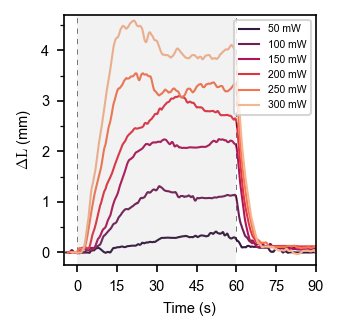

In [5]:
plt.close()
fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in), dpi = 150)
fig.patch.set_facecolor('None')
c0 = 0
L0 = 1 # 1.26 cm
lm = 0
for k in range(c2): lm += h[k][0]
lm /= c2
px = 1332 / 1056 / lm * 10
print(px)

for c in range(c1, c2):
    print(h[c0][0])
    f0 = 1 / h[c0][0] * L0
    x = np.linspace(t[c0].min(), t[c0].max(), N)
    y = np.interp(x, t[c0], h[c0])
    y = px * (y - y[0])
    ysm = savgol_filter(y, window_length=21, polyorder=2, mode='nearest')
    ti = t[c0][int(tOFF[c0])] - 60
    #ax.plot(t[c0]-ti, h[c0], 'o', color = pcolors[c0], alpha = 1, markersize=2, markeredgewidth = 0.2, markeredgecolor='black')
    ax.plot(x-ti, ysm, color = pcolor[c0], label = clab[c], alpha=1, zorder=-1, linewidth=1)
    c0 += 1
ax.plot([60, 60], [0, 300], color='black', linewidth=0.25, linestyle='dashed', dashes=(10, 10), zorder = -1)
ax.plot([0, 0], [0, 300], color='black', linewidth=0.25, linestyle='dashed', dashes=(10, 10), zorder = -5)
    
ax.axvspan(0, 60, facecolor='gray', alpha=0.1, zorder=1)
ax.legend(loc='best',prop=fmg.FontProperties(size=5))
ax.tick_params(axis='both', labelsize=7)
ax.set_ylabel('$\mathrm{\Delta L}$ (mm)', fontsize=7);
ax.set_xlabel('Time (s)', fontsize=7);
ax.set_xlim((-5,90))
ax.set_ylim((-0.25, 4.7))
ax.set_xticks(np.arange(0, 95, 15));
ax.set_yticks(np.arange(0.0, 5, 1));
minor_locator = ticker.FixedLocator(np.arange(0,4.6,0.5))
ax.yaxis.set_minor_locator(minor_locator);

plt.savefig(root + r'/actuation_m734.pdf', format='pdf', dpi=dpi, bbox_inches='tight',pad_inches=0);

0.08949096625706365
140.66021829698948
140.64586353559915
141.10738627389256
141.0147973509452
140.82571660455454
141.43828551753614


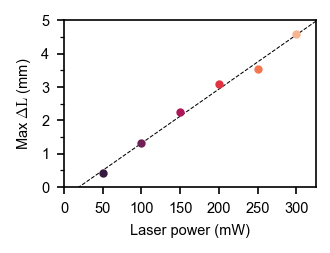

In [6]:
plt.close()
fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in*2/3), dpi = 150)
c0 = 0
L0 = 1 # 1.26 cm
lm = 0
for k in range(c2): lm += h[k][0]
lm /= c2
px = 1332 / 1056 / lm * 10
print(px)
arcmax = np.zeros(6)
for c in range(c1, c2):
    print(h[c0][0])
    f0 = 1 / h[c0][0] * L0
    x = np.linspace(t[c0].min(), t[c0].max(), N)
    y = np.interp(x, t[c0], h[c0])
    y = px * (y - y[0])
    ysm = savgol_filter(y, window_length=21, polyorder=2, mode='nearest')
    ti = t[c0][int(tOFF[c0])] - 60
    #ax.plot(t[c0]-ti, h[c0], 'o', color = pcolors[c0], alpha = 1, markersize=2, markeredgewidth = 0.2, markeredgecolor='black')
    ax.plot(50*(c+1), max(ysm), color = pcolor[c0], label = clab[c], alpha=1, zorder=1, marker='.')
    arcmax[c0] = max(ysm)
    c0 += 1
ax.tick_params(axis='both', labelsize=7)
ax.set_ylabel('Max $\mathrm{\Delta L}$ (mm)', fontsize=7);
ax.set_xlabel('Laser power (mW)', fontsize=7);
ax.set_xlim((0,325))
ax.set_ylim((0.0, 5.0))
ax.set_xticks(np.arange(0, 325, 50));
ax.set_yticks(np.arange(0.0, 5.1, 1));
minor_locator = ticker.FixedLocator(np.arange(0,4.6,0.5))
ax.yaxis.set_minor_locator(minor_locator)
coeff = np.polyfit(50*np.linspace(1,6,6), arcmax, 1)  # Perform a linear fit (degree=1)
xl = np.linspace(0, 350, 100)
ax.plot(xl, coeff[0] * xl + coeff[1], 'k--', zorder = -1, lw=0.5)

plt.savefig(root + r'/actuationMAX_m734.pdf', format='pdf', dpi=dpi, bbox_inches='tight',pad_inches=0);

# Angle VS time

First thing that is needed to do is to load and fix the angles. Ellipses angles change between 0 and 180, so when angle is bellow 0, it will jump to a value below 180 degrees. First thing we need to do is all angles bigger than 90.
Next we need to interpolate the angles variable for the new time variable. And again a Savgol filter is applied (with a rather small window, so the smoothing factor is not big).

The variation between angles is represented.

Some interesting things to notice:
- 50 mW bends around 10 deg and then unbends when the laser goes off. All other intensities, there is unbending after 10-20 seconds.
- When the laser is off, if angle is positive, helices don't go immediately to straight configuration but instead make a bending with negative angle. If angle is negative, there's no oscillation returning.
- For laser intensities 250 and 300 mW, when the angle dips into the negative angle values, helices oscillate.

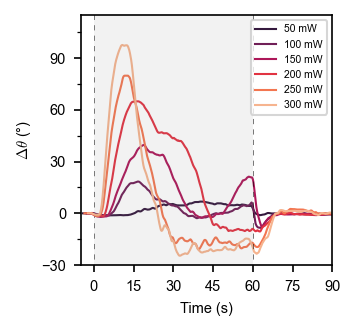

In [7]:
plt.close()
fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in), dpi = 150)
fig.patch.set_facecolor('None')
c0 = 0
for c in range(c1, c2):
    ang1 = el1[c0]
    ang2 = el2[c0]
    ang1[ang1>100] -= 180
    ang2[ang2>100] -= 180
    x = np.linspace(t[c0].min(), t[c0].max(), N)
    y1 = np.interp(x, t[c0], ang1)
    y2 = np.interp(x, t[c0], ang2)
    ysm1 = savgol_filter(y1, window_length=21, polyorder=2, mode='nearest')
    ysm2 = savgol_filter(y2, window_length=21, polyorder=2, mode='nearest')
    ti = t[c0][int(tOFF[c0])]-60
    #ax.plot(t[c0]-ti, ang2-ang1, color = pcolor[c0], markersize=3, markeredgecolor='none', alpha = 1, zorder=3, label = clab[c0])
    dy = ysm2-ysm1
    dy -= dy[0]
    ax.plot(x-ti, dy, color = pcolor[c0], label = clab[c], alpha=1, zorder=-1, linewidth=1)
    c0 += 1

ax.plot([60, 60], [-100, 300], color='black', linewidth=0.25, linestyle='dashed', dashes=(10, 10), zorder = -1)
ax.plot([0, 0], [-100, 300], color='black', linewidth=0.25, linestyle='dashed', dashes=(10, 10), zorder = -2)
    
ax.axvspan(0, 60, facecolor='gray', alpha=0.1, zorder=1)
ax.legend(loc='upper right',prop=fmg.FontProperties(size=5))
ax.tick_params(axis='both', labelsize=7)
ax.set_ylabel(r'$\Delta \theta$ (°)', fontsize=7);
ax.set_xlabel('Time (s)', fontsize=7);
ax.set_xlim((-5,90))
ax.set_xticks(np.arange(0, 95, 15));
ax.set_ylim((-30,115))
ax.set_yticks(np.arange(-30, 105, 30));
minor_locator = ticker.FixedLocator(np.arange(-30,106,15))
ax.yaxis.set_minor_locator(minor_locator)
plt.savefig(root + r'/angle_m734.pdf', format='pdf', dpi=dpi, bbox_inches='tight',pad_inches=0)

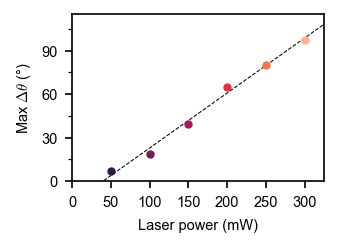

In [6]:
plt.close()
fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in*2/3), dpi = 150)
fig.patch.set_facecolor('None')
c0 = 0
ymax = np.zeros(6)
for c in range(c1, c2):
    ang1 = el1[c0]
    ang2 = el2[c0]
    ang1[ang1>100] -= 180
    ang2[ang2>100] -= 180
    x = np.linspace(t[c0].min(), t[c0].max(), N)
    y1 = np.interp(x, t[c0], ang1)
    y2 = np.interp(x, t[c0], ang2)
    ysm1 = savgol_filter(y1, window_length=21, polyorder=2, mode='nearest')
    ysm2 = savgol_filter(y2, window_length=21, polyorder=2, mode='nearest')
    ti = t[c0][int(tOFF[c0])]-60
    #ax.plot(t[c0]-ti, ang2-ang1, color = pcolor[c0], markersize=3, markeredgecolor='none', alpha = 1, zorder=3, label = clab[c0])
    dy = ysm2-ysm1
    dy -= dy[0]
    ymax[c0] = max(dy) 
    ax.plot(50*(c+1), max(dy), color = pcolor[c0], label = clab[c], alpha=1, zorder=1, marker='.')
    c0 += 1
ax.tick_params(axis='both', labelsize=7)
coeff = np.polyfit(50*np.linspace(1,6,6), ymax, 1)  # Perform a linear fit (degree=1)
xl = np.linspace(0, 350, 100)
ax.plot(xl, coeff[0] * xl + coeff[1], 'k--', zorder = -1, lw=0.5)
ax.set_ylabel(r'Max $\Delta \theta$ (°)', fontsize=7);
ax.set_xlabel('Laser power (mW)', fontsize=7);
ax.set_xlim((0,325))
ax.set_xticks(np.arange(0, 301, 50));
ax.set_ylim((0,115))
ax.set_yticks(np.arange(0, 105, 30));
minor_locator = ticker.FixedLocator(np.arange(-30,106,15))
ax.yaxis.set_minor_locator(minor_locator)
plt.savefig(root + r'/maxangle_m734.pdf', format='pdf', dpi=dpi, bbox_inches='tight',pad_inches=0)

# Temperature VS time (with angle)

In this section I tried to represent all plots of temperature vs time, and how the angle of each ends change over time. Since it is hard to represent the angle, I've separated the temperature plots in the y axis, so in between dashed lines the temperature ranges between 25 C and 80 C. the black lines represent the angle of the ends in respect with a vertical line.

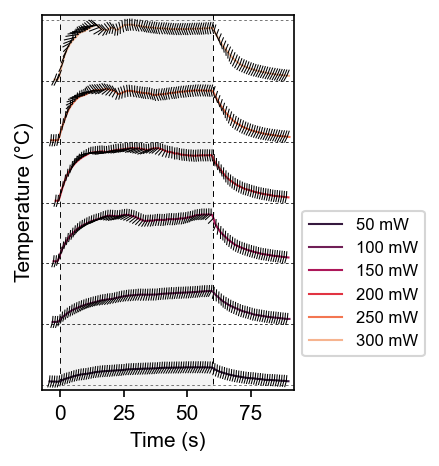

In [51]:
plt.close()
fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in*1.5), dpi = 150)
fig.patch.set_facecolor('None')
c1, c2 = (0,6)
c0 = c1
fact = 55
for c in range(c1, c2):
    ang1 = el1[c0]
    ang2 = el2[c0]
    ang1[ang1>100] -= 180
    ang2[ang2>100] -= 180
    x = np.linspace(t[c0].min(), t[c0].max(), N)
    y1 = np.interp(x, t[c0], ang1)
    y2 = np.interp(x, t[c0], ang2)
    yt = np.interp(x, t[c0], tempMAX[c0])
    ysm = savgol_filter(yt, window_length=21, polyorder=2, mode='nearest')
    ysm1 = savgol_filter(y1, window_length=21, polyorder=2, mode='nearest')
    ysm2 = savgol_filter(y2, window_length=21, polyorder=2, mode='nearest')
    ti = t[c0][int(tOFF[c0])]-60
    ax.plot(x-ti, ysm+fact*c0, color = pcolor[c0], linewidth=1, alpha = 1, label = clab[c0])
    #ax.plot(x-ti, ysm+fact*c0, color = 'k', linewidth=1)
    #ax.plot(x-ti, ysm2, label = str(c), color = pcolor[1], linewidth=0.2)
    
    ax.plot([t[c0][int(tOFF[c0])]-ti, t[c0][int(tOFF[c0])]-ti], [-100,600], color='black', linewidth=0.25, linestyle='dashed', dashes=(10, 10), zorder = -1)
    ax.plot([0, 0], [-100, 600], color='black', linewidth=0.25, linestyle='dashed', dashes=(10, 10), zorder = -2)
    ax.plot([-100, 1000], [25+fact*c0, 25+fact*c0], color='black', linewidth=0.25, linestyle='dashed', dashes=(5, 5), zorder = -2)
    ax.plot([-100, 1000], [80+fact*c0, 80+fact*c0], color='black', linewidth=0.25, linestyle='dashed', dashes=(5, 5), zorder = -2)

    rad = 5
    for k in range(0,len(x),10):
        a0 = x[k]-ti
        a1 = ysm[k]
        a2 = ysm[k]
        b0 = a0 + rad * np.sin((ysm1[k])*np.pi/180)
        b1 = a1 + rad * np.cos((ysm1[k])*np.pi/180)
        b2 = a0 + rad * np.sin((ysm2[k]+180)*np.pi/180)
        b3 = a2 + rad * np.cos((ysm2[k]+180)*np.pi/180)
        ax.plot([a0, b0], [a1+fact*c, b1+fact*c0], 'k', linewidth=0.5)
        ax.plot([a0, b2], [a2+fact*c, b3+fact*c0], 'k', linewidth=0.5)
    c0 += 1
ax.axvspan(0, 60, facecolor='gray', alpha=0.1, zorder=1)
ax.legend(prop=fmg.FontProperties(size=8), bbox_to_anchor=(1, 0.5))
ax.set_ylabel(r'Temperature (°C)')
ax.set_xlabel('Time (s)')
ax.set_xlim((-5-2,90+2))
ax.set_ylim((25-rad, 80+fact*5+rad));
ax.set_yticks([]);

# Actuation VS temperature

These plots should be the best representation of the data in this kind of measurements. However, the behaviour of helices is so rich, it becomes virtually impossible to see anything adequate with this plot.

(140.0, 200.0)

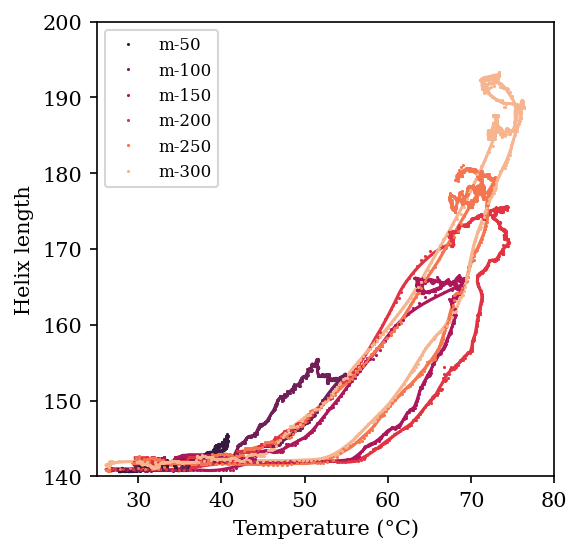

In [144]:
plt.close()
fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in), dpi = 150)
fig.patch.set_facecolor('None')
c0 = 0
for c in range(c1, c2):
    x = np.linspace(t[c0].min(), t[c0].max(), N)
    yACT = np.interp(x, t[c0], h[c0])
    yTEMP = np.interp(x, t[c0], tempMAX[c0])
    ysmA = savgol_filter(yACT, window_length=21, polyorder=2, mode='interp')
    ysmT = savgol_filter(yTEMP, window_length=21, polyorder=2, mode='interp')
    ax.plot(yTEMP, yACT, '.', color = pcolor[c0], markersize=3, markeredgecolor='none', alpha = 1, zorder=3, label = clab[c0])
    ax.plot(ysmT, ysmA, color = pcolor[c0])
    c0 += 1
ax.legend(loc='best', prop=fmg.FontProperties(size=8))
ax.set_ylabel(r'Helix length')
ax.set_xlabel('Temperature (°C)')
ax.set_xlim((25,80))
ax.set_ylim((140, 200));

# Angle VS time (concept)

Here the y axis has no meaning at all. X represents time and each point the angle is depicted with two segments

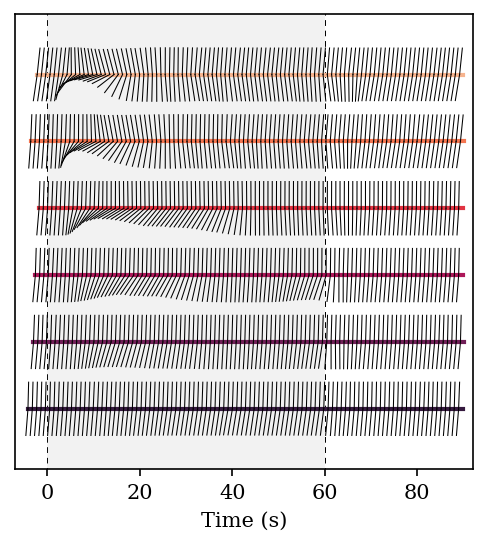

In [190]:
plt.close()
fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in), dpi = 150)
c1, c2 = (0,6)
c0 = c1
fact = 10
for c in range(c1, c2):
    ang1 = el1[c0]
    ang2 = el2[c0]
    ang1[ang1>100] -= 180
    ang2[ang2>100] -= 180
    x = np.linspace(t[c0].min(), t[c0].max(), N)
    y1 = np.interp(x, t[c0], ang1)
    y2 = np.interp(x, t[c0], ang2)
    yt = np.interp(x, t[c0], tempMAX[c0])
    ysm = savgol_filter(yt, window_length=41, polyorder=2, mode='nearest')
    ysm1 = savgol_filter(y1, window_length=21, polyorder=2, mode='nearest')
    ysm2 = savgol_filter(y2, window_length=21, polyorder=2, mode='nearest')
    ti = t[c0][int(tOFF[c0])]-60
    ax.plot(x-ti, 0*ysm+fact*c0, color = pcolor[c0], linewidth=2, alpha = 1, label = clab[c0])
    #ax.plot(x-ti, ysm+fact*c0, color = 'k', linewidth=1)
    #ax.plot(x-ti, ysm2, label = str(c), color = pcolor[1], linewidth=0.2)
    
    ax.plot([t[c0][int(tOFF[c0])]-ti, t[c0][int(tOFF[c0])]-ti], [-100,600], color='black', linewidth=0.25, linestyle='dashed', dashes=(10, 10), zorder = -1)
    ax.plot([0, 0], [-100, 600], color='black', linewidth=0.25, linestyle='dashed', dashes=(10, 10), zorder = -2)
    
    rad = 4
    for k in range(0,len(x),10):
        a0 = x[k]-ti
        a1 = ysm[k]*0
        a2 = ysm[k]*0
        b0 = a0 + rad * np.sin((ysm1[k])*np.pi/180)
        b1 = a1 + rad * np.cos((ysm1[k])*np.pi/180)
        b2 = a0 + rad * np.sin((ysm2[k]+180)*np.pi/180)
        b3 = a2 + rad * np.cos((ysm2[k]+180)*np.pi/180)
        ax.plot([a0, b0], [a1+fact*c, b1+fact*c0], 'k', linewidth=0.5)
        ax.plot([a0, b2], [a2+fact*c, b3+fact*c0], 'k', linewidth=0.5)
    c0 += 1
ax.axvspan(0, 60, facecolor='gray', alpha=0.1, zorder=1)
#ax.legend(prop=fmg.FontProperties(size=8), bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Time (s)')
ax.set_xlim((-5-2,90+2))
ax.set_ylim((0-rad-5, 5+fact*5+rad));
ax.set_yticks([]);